In [24]:
from osgeo import gdal
import rioxarray
import numpy as np
import pyhdf
from pyhdf.SD import SD, SDC
import xarray as xr
import matplotlib.pyplot as plt
import satpy
from satpy import Scene
from pathlib import Path
from glob import glob

TypeError: 'PosixPath' object is not subscriptable

In [28]:
modis_file = Path("/Users/cwelch/Downloads/MOD02QKM.A2025202.2305.061.2025203072926.hdf")
modis_geolocation_file = Path('/Users/cwelch/Downloads/MOD03.A2025202.2305.061.2025203044315.hdf')
modis_file_list = glob(str(modis_file)) + glob(str(modis_geolocation_file))

In [50]:
data_dir = Path("/Users/cwelch/Downloads")
patterns = ("MOD*2026*", "MYD*2026*")
files = [str(p) for pat in patterns for p in data_dir.glob(pat)]

In [51]:

from pyhdf.SD import SD, SDC

# open file
hdf = SD(str(modis_file), SDC.READ)

# list datasets
datasets = hdf.datasets()
print(datasets.keys())


dict_keys(['Latitude', 'Longitude', 'EV_250_RefSB', 'EV_250_RefSB_Uncert_Indexes', 'Band_250M', 'Noise in Thermal Detectors', 'Change in relative responses of thermal detectors', 'DC Restore Change for Thermal Bands', 'DC Restore Change for Reflective 250m Bands', 'DC Restore Change for Reflective 500m Bands', 'DC Restore Change for Reflective 1km Bands'])


In [52]:
files

['/Users/cwelch/Downloads/MOD03.A2026001.0005.061.2026001091851.hdf',
 '/Users/cwelch/Downloads/MOD03.A2026001.0015.061.2026001091953.hdf',
 '/Users/cwelch/Downloads/MOD03.A2026037.0000.061.2026037065158.hdf',
 '/Users/cwelch/Downloads/MOD03.A2026001.0010.061.2026001091840.hdf',
 '/Users/cwelch/Downloads/MOD03.A2026001.0000.061.2026001091836.hdf',
 '/Users/cwelch/Downloads/MYD021KM.A2026001.0005.061.2026001155851.hdf',
 '/Users/cwelch/Downloads/MYD021KM.A2026037.0025.061.2026037175600.hdf',
 '/Users/cwelch/Downloads/MYD021KM.A2026037.0325.061.2026037175528.hdf',
 '/Users/cwelch/Downloads/MYD021KM.A2026037.0015.061.2026037175301.hdf',
 '/Users/cwelch/Downloads/MYD021KM.A2026001.0000.061.2026001160649.hdf',
 '/Users/cwelch/Downloads/MYD021KM.A2026037.0020.061.2026037175311.hdf',
 '/Users/cwelch/Downloads/MYD021KM.A2026037.0030.061.2026037175559.hdf']

In [59]:
scn = Scene(files,
            reader='modis_l1b',
            reader_kwargs={'mask_saturated':True,}
)

In [61]:
scn.calibrate_bt()

AttributeError: 'Scene' object has no attribute 'calibrate_bt'

In [10]:
lat = hdf.select("Latitude")[:]
lon = hdf.select("Longitude")[:]
refl = hdf.select("EV_250_RefSB")[:]

In [11]:
attrs = hdf.select("EV_250_RefSB").attributes()
attrs

{'long_name': 'Earth View 250M Reflective Solar Bands Scaled Integers',
 'units': 'none',
 'valid_range': [0, 32767],
 '_FillValue': 65535,
 'band_names': '1,2',
 'radiance_scales': [0.03064458817243576, 0.011372211389243603],
 'radiance_offsets': [-0.0, -0.0],
 'radiance_units': 'Watts/m^2/micrometer/steradian',
 'reflectance_scales': [6.187688268255442e-05, 3.717148501891643e-05],
 'reflectance_offsets': [-0.0, -0.0],
 'reflectance_units': 'none',
 'corrected_counts_scales': [0.12497329711914062, 0.12497329711914062],
 'corrected_counts_offsets': [-0.0, -0.0],
 'corrected_counts_units': 'counts'}

In [40]:
masked = np.ma.masked_equal(refl, 65535)

In [44]:
masked[0]

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [695, 697, 664, ..., 1677, 2191, 2628],
        [719, 705, 690, ..., 1575, 2052, 2540],
        [715, 705, 687, ..., 1502, 1793, 2442]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=65535,
  dtype=uint16)

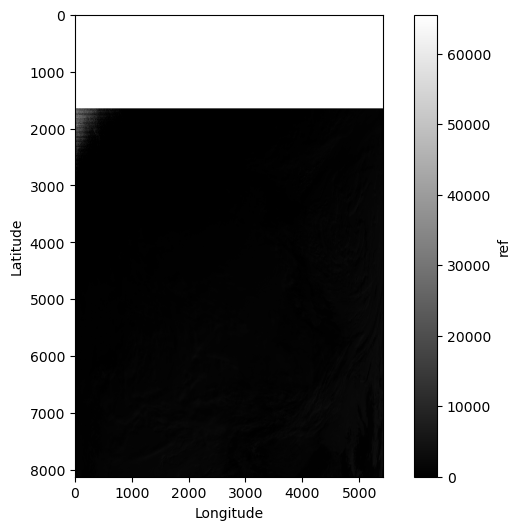

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.imshow(masked[0], cmap='gray')
plt.colorbar(label="ref")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
